<p style="text-align:right;">Daniel Böckenhoff, Max-Planck-Institute for Plasmaphysics</p>

## Convolutional Neural Networks to Reconstruct Proxies for Magnetic Equilibrium Properties from Heat Load Images

This exercise is working on the data set and scenario described in [this paper](https://iopscience.iop.org/article/10.1088/1741-4326/ab4123). Please read the introduction of this paper before you continue.

**What you will learn:**
 - How to build a real time capable model to extract physical information hidden in images
 - Problems concerning heat load control in stellarator plasmas
 - Use a model for regression  instead of classification
 
**Task:**
Carefully read the cells and execute them (Shift enter or menu panel). Complete the exercises marked as such.

## Image Data Preparation
We will load the pre-computed simualtion data set of the (near) vacuum field strike line which depends on a proxy for the radial shift of the magnetic axis of the nested magnetic field surfaces with respect to the vacuum magnetic configuration and the rotational transform of the magnetic edge.

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import os
import sklearn.model_selection
import sklearn.metrics
import matplotlib.pyplot as plt

In [2]:
# Set the path to the directory where we have already downloaded the data
local_path = !pwd # under linux/mac
data_path = local_path[0] + '/../data/iota-shift.npz'

# Load the data
data = np.load(data_path)

inputs = data['arr_0']
inputs = inputs.reshape(len(inputs), *data['reshape'], 1)
input_shape = inputs.shape[1:]

labels = np.stack([data['shift_hat'], data['iota_hat']], axis=1)

## split trianing, validation and test 80/10/10
x_train, x_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(
        inputs,
        labels,
        random_state=42,
        )

num_imgs = len(y_train) + len(y_test)

print("Number of samples in whole data set: {num_imgs}".format(**locals()))

Number of samples in whole data set: 27178


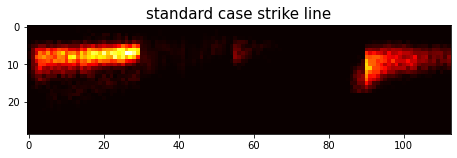

In [3]:
# Plot the standard case strikeline (standard case: iota_hat=0, shift_hat=0)
standard_case_index_shift, standard_case_index_iota = np.where(labels == [0,0])
standard_case_index = 0
assert (labels[standard_case_index] == 0.).all()
standard_case_image = inputs[standard_case_index]
standard_case_image = np.reshape(standard_case_image, data["reshape"])
fig, axes = plt.subplots(figsize=(18, 2))
axes.imshow(standard_case_image.T, cmap='hot', aspect='equal')
_ = axes.set_title("standard case strike line (n_hits per area [1/m²])", fontsize=15) 

## Make TensorFlow Datasets


**Note:** Training, Validation and Test Split.
A rule of thumb is to split the data set in taining, validation and test set by the ratio 80:10:10.

## Define and Train a Convolutional Neural Network
**Layer types:**
 - Conv2D convolutional layer, here inputs are 3dim and the convolution sums over the 3rd dim.
 - MaxPooling2D takes local maxima over a rectangular region.
 - Dropout randomly deactivates neurons during training, which can make training more robust.
 - [BatchNormalization](https://arxiv.org/pdf/1502.03167.pdf), centralizes and scales its input to have approximately 0 mean and variance 1.



**Exercise:**
 1. Try to solve the regression problem with tf.keras with the methods you learned before


In [4]:
log_basedir = os.path.join("logs", "iota_shift/")

def train(model, x_train, y_train, epochs=20, batch_size=25, log_basedir=log_basedir):
    # Callbacks: What should be done during (long) training?

    # Function to store model to file, if validation loss has a new record
    # Check always after having seen at least another save_freq examples.
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model.name + '.h5',
        save_weights_only=False,  # save the entire model, not only the weights. This allows re-building the whole model
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1)

    # Function to decrease learning rate by 'factor'
    # when there has been no significant improvement in the last 'patience' epochs.
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', mode='min', factor=0.75, patience=3, verbose=1)

    # Use tensorboard to show the progress. See cell below for instructions on how to use tensorboard
    log_dir = log_basedir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "-" + model.name

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir,
        histogram_freq=1,  # frequency (in epochs) at which to compute activation and weight histograms for the layers
        write_images=False,  # whether to write model weights to visualize as image in TensorBoard.
    )
                         
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        validation_split=0.1,
                        callbacks=[checkpoint, reduce_lr, tensorboard_callback]
                       )
    return history

In [5]:
# Your code here to solve Exercise 1.
# ...

In [7]:
# FF-FC_PBI from doi:10.1088/1741-4326/ab4123

np.random.seed(1)  # so we all get the same pseudorandom results

model = tf.keras.models.Sequential(name="iota_shift_ffpbi")  # sequential stack of layers

model.add(tf.keras.layers.Input(input_shape))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(80, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add( tf.keras.layers.Dense(2, activation=None))

# Configure the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.mean_squared_error,
              metrics=[
                  tf.keras.metrics.RootMeanSquaredError(),
                  tf.keras.metrics.MeanAbsoluteError(),
              ])

# pretty print a summary of the layer types and dimensions
model.summary()

history = train(model, x_train, y_train, epochs=100, batch_size=25, log_basedir=log_basedir)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_rmse, test_mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("rmse on test set:", test_rmse)
print("mae on test set:", test_mae)

Model: "iota_shift_ffpbi"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 113, 29, 1)        4         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3277)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                262240    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               8100      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 270,546
Trainable params: 270,544
Non-trainable params: 2
_________________________________________________________________
Epoch 1/100
729/734 [============================>.] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.152

Epoch 17/100
733/734 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0323 - mean_absolute_error: 0.0247
Epoch 00017: val_loss did not improve from 0.00089
734/734 [==============================] - 9s 12ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323 - mean_absolute_error: 0.0247 - val_loss: 9.6663e-04 - val_root_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.0236 - lr: 7.5000e-04
Epoch 18/100
733/734 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0321 - mean_absolute_error: 0.0247
Epoch 00018: val_loss improved from 0.00089 to 0.00082, saving model to iota_shift_ffpbi.h5

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
734/734 [==============================] - 13s 17ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - mean_absolute_error: 0.0247 - val_loss: 8.1910e-04 - val_root_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.0213 - lr: 7.5000

Epoch 34/100
727/734 [============================>.] - ETA: 0s - loss: 3.9355e-04 - root_mean_squared_error: 0.0198 - mean_absolute_error: 0.0153
Epoch 00034: val_loss did not improve from 0.00036

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.00017797851614886895.
734/734 [==============================] - 7s 9ms/step - loss: 3.9463e-04 - root_mean_squared_error: 0.0199 - mean_absolute_error: 0.0153 - val_loss: 4.3980e-04 - val_root_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.0159 - lr: 2.3730e-04
Epoch 35/100
734/734 [==============================] - ETA: 0s - loss: 3.5373e-04 - root_mean_squared_error: 0.0188 - mean_absolute_error: 0.0144
Epoch 00035: val_loss improved from 0.00036 to 0.00033, saving model to iota_shift_ffpbi.h5
734/734 [==============================] - 8s 11ms/step - loss: 3.5373e-04 - root_mean_squared_error: 0.0188 - mean_absolute_error: 0.0144 - val_loss: 3.3301e-04 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.01

Epoch 51/100
731/734 [============================>.] - ETA: 0s - loss: 2.5317e-04 - root_mean_squared_error: 0.0159 - mean_absolute_error: 0.0122
Epoch 00051: val_loss improved from 0.00026 to 0.00026, saving model to iota_shift_ffpbi.h5
734/734 [==============================] - 5s 7ms/step - loss: 2.5299e-04 - root_mean_squared_error: 0.0159 - mean_absolute_error: 0.0122 - val_loss: 2.5689e-04 - val_root_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0118 - lr: 5.6314e-05
Epoch 52/100
733/734 [============================>.] - ETA: 0s - loss: 2.5222e-04 - root_mean_squared_error: 0.0159 - mean_absolute_error: 0.0121
Epoch 00052: val_loss improved from 0.00026 to 0.00025, saving model to iota_shift_ffpbi.h5

Epoch 00052: ReduceLROnPlateau reducing learning rate to 4.223513315082528e-05.
734/734 [==============================] - 10s 14ms/step - loss: 2.5215e-04 - root_mean_squared_error: 0.0159 - mean_absolute_error: 0.0121 - val_loss: 2.4899e-04 - val_root_mean_squared_erro

Epoch 68/100
734/734 [==============================] - ETA: 0s - loss: 2.2262e-04 - root_mean_squared_error: 0.0149 - mean_absolute_error: 0.0113
Epoch 00068: val_loss did not improve from 0.00023
734/734 [==============================] - 7s 10ms/step - loss: 2.2262e-04 - root_mean_squared_error: 0.0149 - mean_absolute_error: 0.0113 - val_loss: 2.3821e-04 - val_root_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0113 - lr: 1.0023e-05
Epoch 69/100
730/734 [============================>.] - ETA: 0s - loss: 2.1624e-04 - root_mean_squared_error: 0.0147 - mean_absolute_error: 0.0112
Epoch 00069: val_loss did not improve from 0.00023
734/734 [==============================] - 9s 13ms/step - loss: 2.1666e-04 - root_mean_squared_error: 0.0147 - mean_absolute_error: 0.0112 - val_loss: 2.3590e-04 - val_root_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0114 - lr: 1.0023e-05
Epoch 70/100
731/734 [============================>.] - ETA: 0s - loss: 2.1567e-04 - root_mean_squared

In [10]:
# CNN from doi:10.1088/1741-4326/ab4123

np.random.seed(1)  # so we all get the same pseudorandom results

model = tf.keras.models.Sequential(name="iota_shift_cnn")  # sequential stack of layers

model.add(tf.keras.layers.Input(input_shape))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(8, 5, activation='relu', name="conv_1"))
model.add(tf.keras.layers.Conv2D(12, 3, activation='relu', padding='same', name="conv_2"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', name="conv_3"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add( tf.keras.layers.Dense(2, activation=None))

# Configure the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.mean_squared_error,
              metrics=[
                  tf.keras.metrics.RootMeanSquaredError(),
                  tf.keras.metrics.MeanAbsoluteError(),
              ])

# pretty print a summary of the layer types and dimensions
model.summary()

history = train(model, x_train, y_train, epochs=100, batch_size=25, log_basedir=log_basedir)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_rmse, test_mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("rmse on test set:", test_rmse)
print("mae on test set:", test_mae)

Model: "iota_shift_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 113, 29, 1)        4         
_________________________________________________________________
conv_1 (Conv2D)              (None, 109, 25, 8)        208       
_________________________________________________________________
conv_2 (Conv2D)              (None, 109, 25, 12)       876       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 13, 12)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 55, 13, 16)        1744      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 7, 16)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)           

Epoch 16/100
734/734 [==============================] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0322 - mean_absolute_error: 0.0243
Epoch 00016: val_loss improved from 0.00082 to 0.00079, saving model to iota_shift_cnn.h5
734/734 [==============================] - 275s 375ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - mean_absolute_error: 0.0243 - val_loss: 7.9289e-04 - val_root_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.0210 - lr: 7.5000e-04
Epoch 17/100
734/734 [==============================] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0317 - mean_absolute_error: 0.0240
Epoch 00017: val_loss did not improve from 0.00079

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
734/734 [==============================] - 296s 403ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - mean_absolute_error: 0.0240 - val_loss: 7.9946e-04 - val_root_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.0222 - lr: 7.5

Epoch 33/100
734/734 [==============================] - ETA: 0s - loss: 3.9139e-04 - root_mean_squared_error: 0.0198 - mean_absolute_error: 0.0150
Epoch 00033: val_loss improved from 0.00040 to 0.00039, saving model to iota_shift_cnn.h5
734/734 [==============================] - 95s 129ms/step - loss: 3.9139e-04 - root_mean_squared_error: 0.0198 - mean_absolute_error: 0.0150 - val_loss: 3.9369e-04 - val_root_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.0149 - lr: 1.7798e-04
Epoch 34/100
734/734 [==============================] - ETA: 0s - loss: 3.8762e-04 - root_mean_squared_error: 0.0197 - mean_absolute_error: 0.0149
Epoch 00034: val_loss did not improve from 0.00039

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0001334838816546835.
734/734 [==============================] - 92s 126ms/step - loss: 3.8762e-04 - root_mean_squared_error: 0.0197 - mean_absolute_error: 0.0149 - val_loss: 3.9678e-04 - val_root_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.

Epoch 50/100
734/734 [==============================] - ETA: 0s - loss: 2.8512e-04 - root_mean_squared_error: 0.0169 - mean_absolute_error: 0.0127
Epoch 00050: val_loss improved from 0.00033 to 0.00032, saving model to iota_shift_cnn.h5
734/734 [==============================] - 90s 122ms/step - loss: 2.8512e-04 - root_mean_squared_error: 0.0169 - mean_absolute_error: 0.0127 - val_loss: 3.2315e-04 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0135 - lr: 4.2235e-05
Epoch 51/100
734/734 [==============================] - ETA: 0s - loss: 2.8505e-04 - root_mean_squared_error: 0.0169 - mean_absolute_error: 0.0127
Epoch 00051: val_loss did not improve from 0.00032

Epoch 00051: ReduceLROnPlateau reducing learning rate to 3.167634986311896e-05.
734/734 [==============================] - 95s 130ms/step - loss: 2.8505e-04 - root_mean_squared_error: 0.0169 - mean_absolute_error: 0.0127 - val_loss: 3.2764e-04 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.

Epoch 67/100
733/734 [============================>.] - ETA: 0s - loss: 2.6355e-04 - root_mean_squared_error: 0.0162 - mean_absolute_error: 0.0121
Epoch 00067: val_loss did not improve from 0.00031
734/734 [==============================] - 103s 140ms/step - loss: 2.6349e-04 - root_mean_squared_error: 0.0162 - mean_absolute_error: 0.0121 - val_loss: 3.1123e-04 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0133 - lr: 7.5169e-06
Epoch 68/100
733/734 [============================>.] - ETA: 0s - loss: 2.6132e-04 - root_mean_squared_error: 0.0162 - mean_absolute_error: 0.0121
Epoch 00068: val_loss did not improve from 0.00031
734/734 [==============================] - 93s 126ms/step - loss: 2.6130e-04 - root_mean_squared_error: 0.0162 - mean_absolute_error: 0.0121 - val_loss: 3.1120e-04 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0133 - lr: 7.5169e-06
Epoch 69/100
733/734 [============================>.] - ETA: 0s - loss: 2.6088e-04 - root_mean_sq

Loss on test set: 0.0003270617744419724
rmse on test set: 0.018084850162267685
mae on test set: 0.013475175015628338


In [11]:
# DCNN from doi:10.1088/1741-4326/ab4123

np.random.seed(1)  # so we all get the same pseudorandom results

model = tf.keras.models.Sequential(name="iota_shift_dcnn")  # sequential stack of layers

model.add(tf.keras.layers.Input(input_shape))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(6, 3, activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(6, 3, activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(12, 3, activation='relu', strides=(2, 1)))
model.add(tf.keras.layers.Conv2D(12, 5, activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(18, 5, activation='relu', strides=(2, 1)))
model.add(tf.keras.layers.Conv2D(30, (7, 5), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(30, (1, 7), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(42, 3, activation='relu', strides=(2, 2)))
model.add(tf.keras.layers.Conv2D(48, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(72, 3, activation='relu'))
model.add(tf.keras.layers.Conv2D(108, 1, activation='relu'))
model.add(tf.keras.layers.AveragePooling2D(pool_size=(3, 2)))
model.add(tf.keras.layers.Flatten())
model.add( tf.keras.layers.Dense(2, activation=None))

# Configure the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.mean_squared_error,
              metrics=[
                  tf.keras.metrics.RootMeanSquaredError(),
                  tf.keras.metrics.MeanAbsoluteError(),
              ])

# pretty print a summary of the layer types and dimensions
model.summary()

history = train(model, x_train, y_train, epochs=100, batch_size=100, log_basedir=log_basedir)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_rmse, test_mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("rmse on test set:", test_rmse)
print("mae on test set:", test_mae)

Model: "iota_shift_dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 113, 29, 1)        4         
_________________________________________________________________
conv2d (Conv2D)              (None, 113, 29, 6)        60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 29, 6)        330       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 27, 12)        660       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 27, 12)        3612      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 23, 18)        5418      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 23, 30)    

Epoch 14/100
184/184 [==============================] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0602 - mean_absolute_error: 0.0448
Epoch 00014: val_loss improved from 0.00158 to 0.00157, saving model to iota_shift_dcnn.h5
184/184 [==============================] - 552s 3s/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - mean_absolute_error: 0.0448 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.0311 - lr: 7.5000e-04
Epoch 15/100
184/184 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0512 - mean_absolute_error: 0.0388
Epoch 00015: val_loss did not improve from 0.00157
184/184 [==============================] - 520s 3s/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - mean_absolute_error: 0.0388 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736 - val_mean_absolute_error: 0.0608 - lr: 7.5000e-04
Epoch 16/100
184/184 [==============================] - ETA: 0s - loss: 0.0045 - root_

Epoch 32/100
184/184 [==============================] - ETA: 0s - loss: 9.2068e-04 - root_mean_squared_error: 0.0303 - mean_absolute_error: 0.0229
Epoch 00032: val_loss did not improve from 0.00056
184/184 [==============================] - 279s 2s/step - loss: 9.2068e-04 - root_mean_squared_error: 0.0303 - mean_absolute_error: 0.0229 - val_loss: 7.7074e-04 - val_root_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.0211 - lr: 1.7798e-04
Epoch 33/100
184/184 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0273
Epoch 00033: val_loss did not improve from 0.00056

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0001334838816546835.
184/184 [==============================] - 290s 2s/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0273 - val_loss: 7.3186e-04 - val_root_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.0202 - lr: 1.7798e-04
Epoch 34/100
184/184 [=======

184/184 [==============================] - ETA: 0s - loss: 7.4933e-04 - root_mean_squared_error: 0.0274 - mean_absolute_error: 0.0205
Epoch 00049: val_loss did not improve from 0.00042

Epoch 00049: ReduceLROnPlateau reducing learning rate to 3.167634986311896e-05.
184/184 [==============================] - 288s 2s/step - loss: 7.4933e-04 - root_mean_squared_error: 0.0274 - mean_absolute_error: 0.0205 - val_loss: 9.6513e-04 - val_root_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.0243 - lr: 4.2235e-05
Epoch 50/100
184/184 [==============================] - ETA: 0s - loss: 5.9573e-04 - root_mean_squared_error: 0.0244 - mean_absolute_error: 0.0185
Epoch 00050: val_loss did not improve from 0.00042
184/184 [==============================] - 272s 1s/step - loss: 5.9573e-04 - root_mean_squared_error: 0.0244 - mean_absolute_error: 0.0185 - val_loss: 4.5132e-04 - val_root_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.0162 - lr: 3.1676e-05
Epoch 51/100
184/184 [============

184/184 [==============================] - ETA: 0s - loss: 5.4143e-04 - root_mean_squared_error: 0.0233 - mean_absolute_error: 0.0176
Epoch 00066: val_loss did not improve from 0.00037

Epoch 00066: ReduceLROnPlateau reducing learning rate to 7.516946425312199e-06.
184/184 [==============================] - 285s 2s/step - loss: 5.4143e-04 - root_mean_squared_error: 0.0233 - mean_absolute_error: 0.0176 - val_loss: 3.8897e-04 - val_root_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.0150 - lr: 1.0023e-05
Epoch 67/100
184/184 [==============================] - ETA: 0s - loss: 5.3280e-04 - root_mean_squared_error: 0.0231 - mean_absolute_error: 0.0175
Epoch 00067: val_loss improved from 0.00037 to 0.00035, saving model to iota_shift_dcnn.h5
184/184 [==============================] - 269s 1s/step - loss: 5.3280e-04 - root_mean_squared_error: 0.0231 - mean_absolute_error: 0.0175 - val_loss: 3.5490e-04 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0143 - lr: 7.516

Epoch 83/100
184/184 [==============================] - ETA: 0s - loss: 5.0281e-04 - root_mean_squared_error: 0.0224 - mean_absolute_error: 0.0169
Epoch 00083: val_loss did not improve from 0.00035
184/184 [==============================] - 280s 2s/step - loss: 5.0281e-04 - root_mean_squared_error: 0.0224 - mean_absolute_error: 0.0169 - val_loss: 3.5347e-04 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0143 - lr: 1.7838e-06
Epoch 84/100
184/184 [==============================] - ETA: 0s - loss: 5.0201e-04 - root_mean_squared_error: 0.0224 - mean_absolute_error: 0.0169
Epoch 00084: val_loss improved from 0.00035 to 0.00035, saving model to iota_shift_dcnn.h5

Epoch 00084: ReduceLROnPlateau reducing learning rate to 1.3378548828768544e-06.
184/184 [==============================] - 273s 1s/step - loss: 5.0201e-04 - root_mean_squared_error: 0.0224 - mean_absolute_error: 0.0169 - val_loss: 3.5237e-04 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.01

Epoch 100/100
184/184 [==============================] - ETA: 0s - loss: 4.7837e-04 - root_mean_squared_error: 0.0219 - mean_absolute_error: 0.0166
Epoch 00100: val_loss did not improve from 0.00035
184/184 [==============================] - 256s 1s/step - loss: 4.7837e-04 - root_mean_squared_error: 0.0219 - mean_absolute_error: 0.0166 - val_loss: 3.5325e-04 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0143 - lr: 3.1748e-07
Loss on test set: 0.00036712130531668663
rmse on test set: 0.01916041038930416
mae on test set: 0.014472809620201588


In [ ]:
def plot_weights(layer, n_filters=None, n_channels=None):
    # retrieve weights from the second hidden layer
    filters, biases = layer.get_weights()
    
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    n_channels = n_channels or filters.shape[2]
    n_filters = n_filters or filters.shape[3]
    
    img_idx = 1
    artists = []
    for i_fil in range(n_filters):
        for i_chan in range(n_channels):
            # specify subplot and turn of axis
            ax = plt.subplot(n_filters, n_channels, img_idx)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            artists.append(plt.imshow(filters[:, :, i_chan, i_fil], cmap='gray'))
            img_idx += 1
    return artists

plot_weights(model.get_layer('conv_1'))
plt.show()

In [12]:
%load_ext tensorboard
%tensorboard --logdir log_basedir  # start tensorboard with ipython magic command

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Evaluation after Training

In [ ]:
# Load the parameters with the best validation accuracy during training.
# This works also if you interruped the training!
model.load_weights(model.name + '.h5')
test_loss = model.evaluate(x_test, y_test, verbose = 0)
print("Loss on test set:", test_loss)

In [ ]:
# make predictions
predictions = model.predict(x_test)

In [ ]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

ax[0].scatter(y_test[:, 0], predictions[:, 0], alpha=0.01)
ax[0].set_title('Prediction')
ax[0].set_xlabel('I_A expected')
ax[0].set_ylabel('I_A predicted')

ax[1].scatter(y_test[:, 1], predictions[:, 1], alpha=0.01)
ax[1].set_title('Prediction')
ax[1].set_xlabel('I_B expected')
ax[1].set_ylabel('I_B predicted')

plt.show()